In [110]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# pd.set_option('display.max_colwidth', 150000) # view everything
import sys
sys.path.insert(1, '../')
import research
from research import nlp_eda
import re
import pickle 
import pyLDAvis
import os
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
paths = {'all_data': '../data/merged_df.csv'}
all_data = pd.read_csv(paths['all_data'], index_col = 0)

In [3]:
all_data.head()

Description  Location       Job Title
0  \n\n\nThis position can be based remotely anyw...  new york  data scientist
1  \n\nSummary\n \nImagine what you could do here...     texas  data scientist
2  \nLead analytics and measurement efforts for s...     other  data scientist
3  \nAbout Gusto\n\nGusto is a modern, online peo...     other  data scientist
4  \n\nSummary\n \nAt Apple, new ideas have a way...     texas  data scientist

In [4]:
all_data.shape

(1703, 3)

In [20]:
# Subsetting into data scientist vs data analyst
ds = all_data[all_data["Job Title"] == 'data scientist']
da = all_data[all_data["Job Title"] == 'data analyst']

In [5]:
# Creating an object where my NLP EDA functions are located
nlp = nlp_eda()

In [12]:
def preprocess(seq):
    ''' Preprocessing pipeline '''
    
    # Removing punctuation
    seq = seq.map(lambda x: re.sub('[,\.!?]', '', x))
    
    # Converting to lowercase
    seq = seq.map(lambda x: x.lower())
    
    return seq

In [27]:
ds = preprocess(ds['Description'])

In [28]:
ds

0      \n\n\nthis position can be based remotely anyw...
1      \n\nsummary\n \nimagine what you could do here...
2      \nlead analytics and measurement efforts for s...
3      \nabout gusto\n\ngusto is a modern online peop...
4      \n\nsummary\n \nat apple new ideas have a way ...
                             ...                        
317    description\nsentient energy - a koch engineer...
349    truveris is a leading digital health company f...
354    job summary\nresponsible for leveraging intern...
361    businesses raytheon technologies corporate\njo...
57     wes is looking for a bi analyst / data scienti...
Name: Description, Length: 457, dtype: object

In [24]:
# help(a)

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


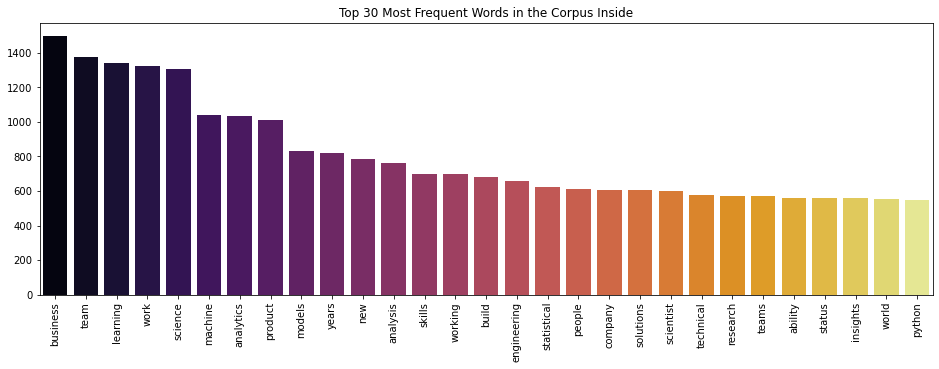

In [29]:
# Visualizing the descriptions of my data
nlp.visualize_counts(ds)

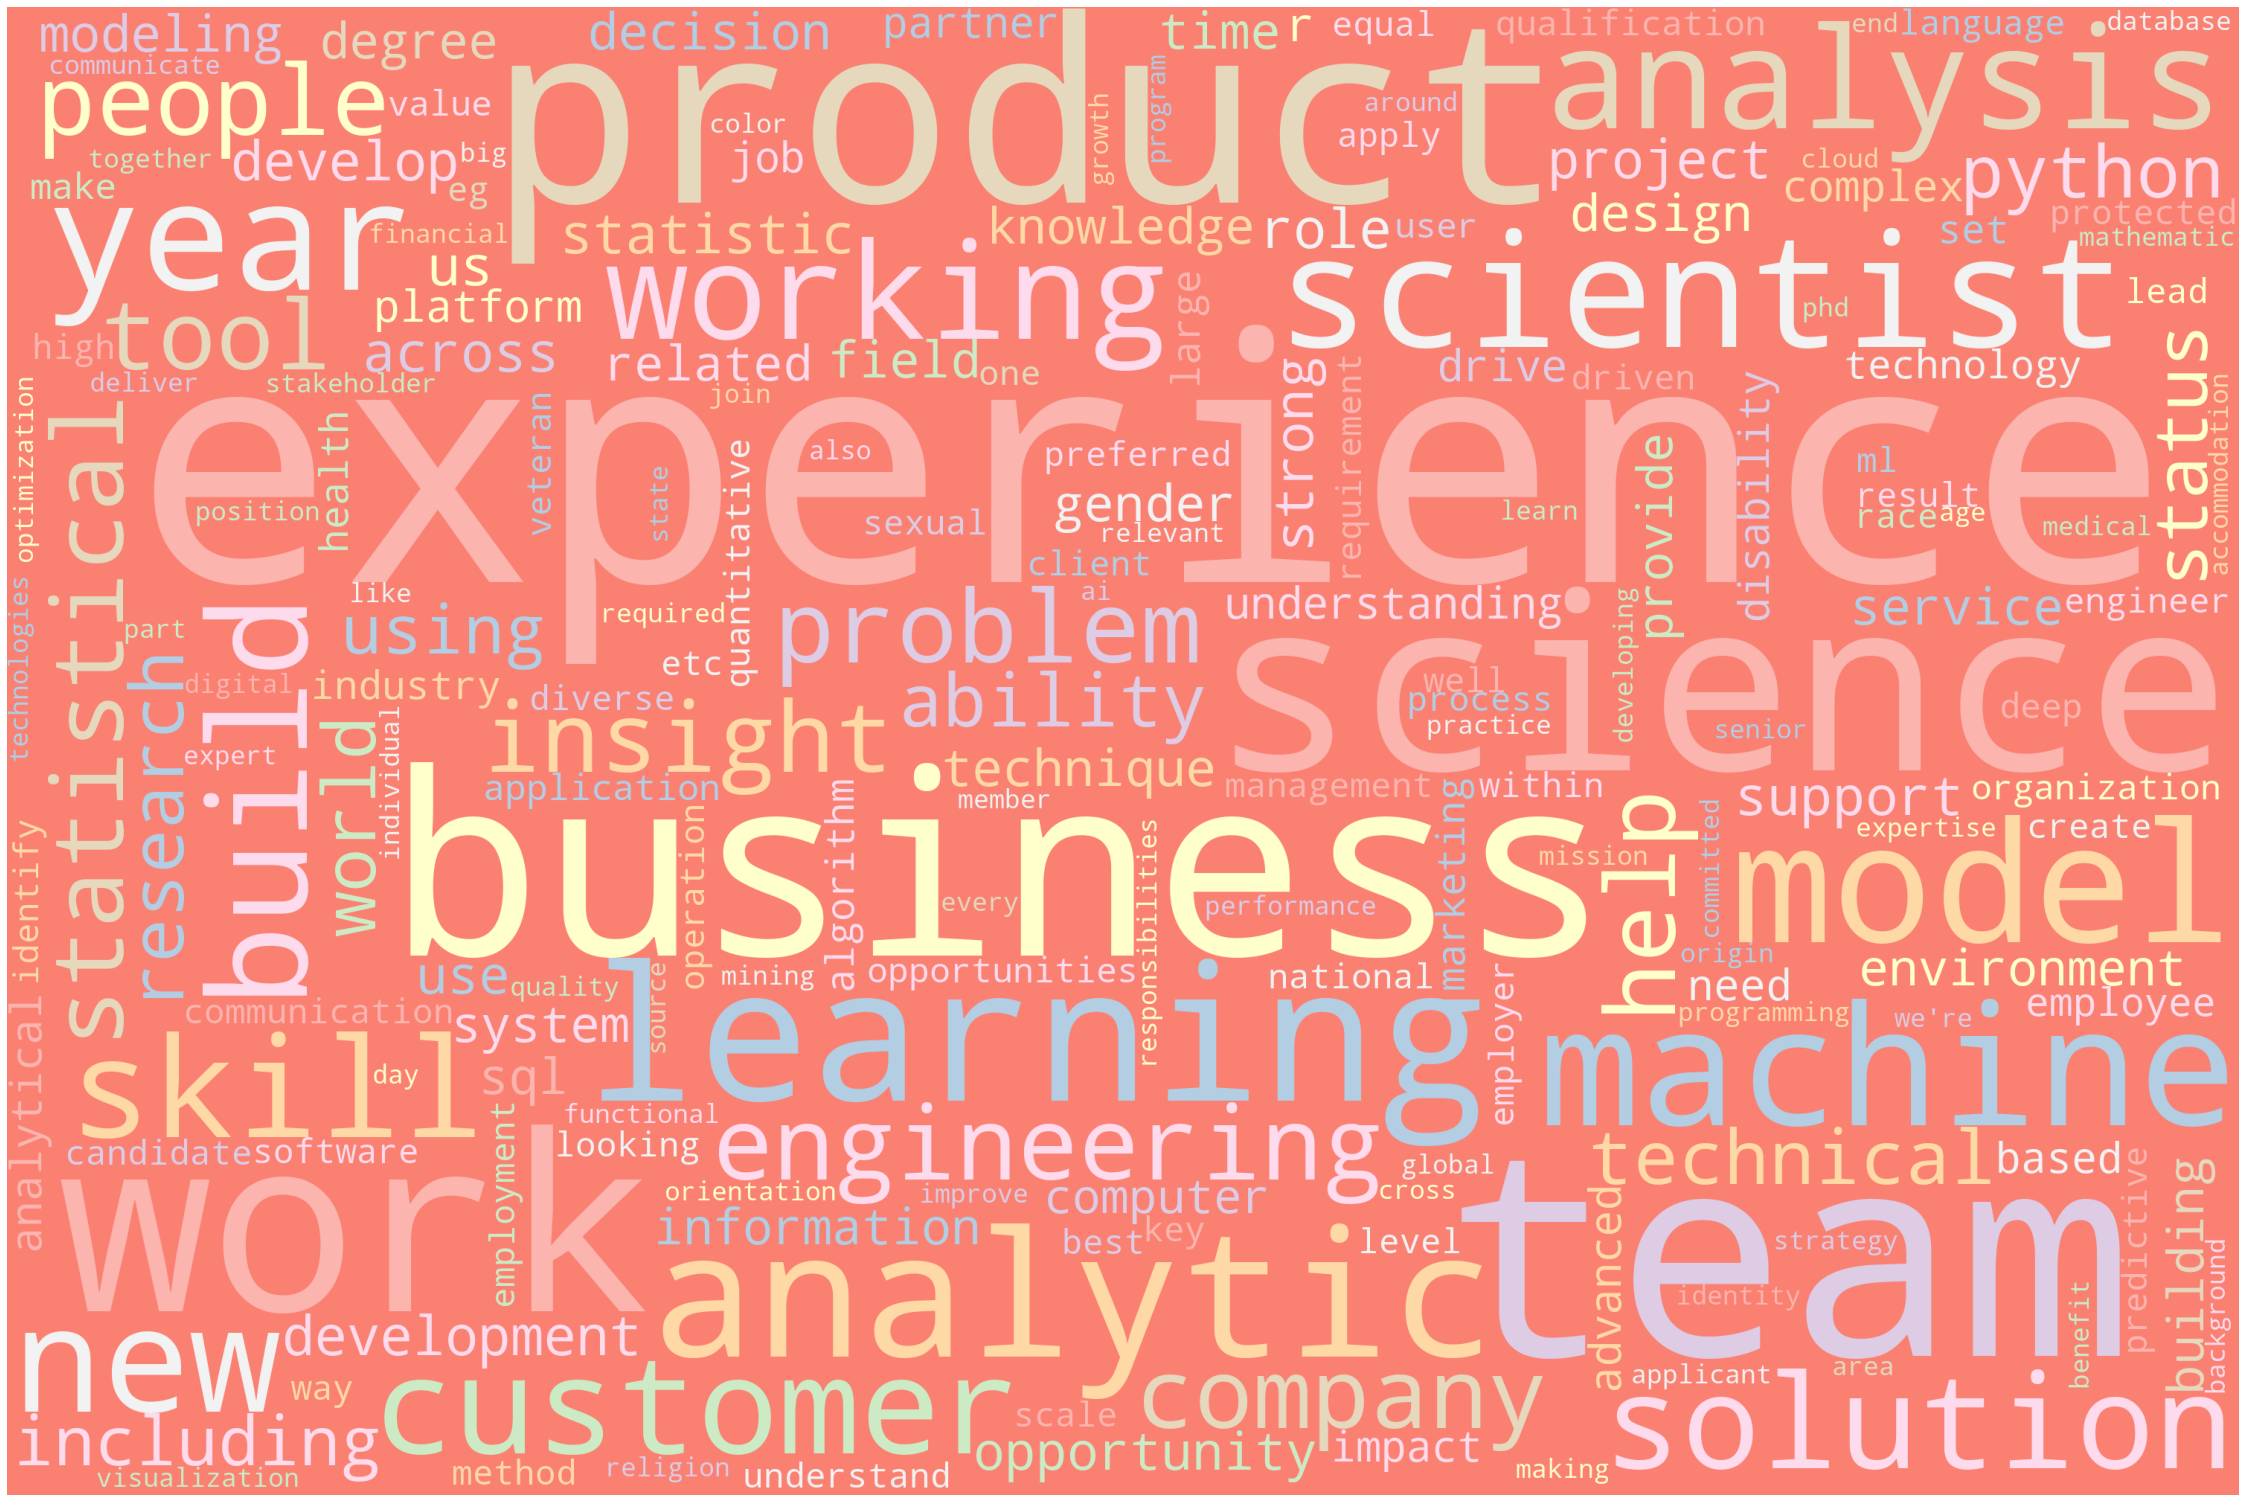

In [30]:
nlp.word_cloud(ds)

In [31]:
bow = nlp.to_wcdf(ds)

In [32]:
bow.head()

00  10  100  10000  100000  1100  12  13  15  15000  ...  write  writes  \
0   0   0    0      0       0     0   0   0   0      0  ...      0       0   
1   0   0    0      0       0     0   0   0   0      0  ...      0       0   
2   0   0    0      0       0     0   0   0   0      0  ...      0       0   
3   0   0    0      0       2     0   0   0   0      0  ...      0       0   
4   0   0    0      0       0     0   0   0   0      0  ...      0       0   

   writing  written  year  years  yes  yet  yield  york  
0        0        0     0      1    0    0      0     0  
1        0        0     0      1    0    0      0     0  
2        0        0     0      1    0    0      0     0  
3        0        0     0      3    0    0      0     2  
4        0        0     0      0    0    0      0     0  

[5 rows x 3412 columns]

# LDA

Helpful articles: [1](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2), [2](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158), [3](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)

Note: A lot of the content here is paraphrased from source 2 above

And the goal of LDA is to map all the documents to the topics in a way, such that the words in each document are mostly captured by those imaginary topics.

We want to solve:

$$
P(\theta_{1:M}, z_{1:M}, \beta_{1:K}|D:\alpha_{1:M},\eta_{1:k})
$$

This is just saying:

    I have a set of M documents, each document having N words, where each word is generated by a single topic from a set of K topics. I’m looking for the joint posterior probability of


Each document can be described by a distribution of topics and each topic can be described by a distribution of word



$\theta$ (distributional parameter) or $P(\text{topic } t|\text{document } d)$: 
_The proportion of words in document d that are assigned to topic t. This tries to capture how many words belong to topic t for a given document d excluding the current word. If a lot of words from d belong to t, there is a higher probability that word w belongs to t._

Next we have:

$\beta$ (distributional parameter) or $P(\text{word } w|\text{topic } t)$: _The proportion of assignments to topic t over all documents that come from this word w. This tries to capture how many documents are in topic t because of the word w._

* k — Number of topics a document belongs to (a fixed number)
* V — Size of the vocabulary
* M — Number of documents
* N — Number of words in each document
* w — A word in a document. This is represented as a one hot encoded vector of size V (i.e. V — vocabulary size)
* w (bold w): represents a document (i.e. vector of “w”s) of N words
* D — Corpus, a collection of M documents
* z — A topic from a set of k topics. A topic is a distribution words. For example it might be, Animal = (0.3 Cats, 0.4 Dogs, 0 AI, 0.2 Loyal, 0.1 Evil)


One of the way to solve this is through a Variational Inference optimization problem!

For this research project, I will be referencing [this](https://github.com/kapadias/mediumposts/blob/master/natural_language_processing/topic_modeling/notebooks/Introduction%20to%20Topic%20Modeling.ipynb) implementation.

In [38]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [46]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
              
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
         if word not in stop_words] for doc in texts]

In [49]:
data = ds.values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)


In [50]:
data_words

[['position',
  'based',
  'remotely',
  'anywhere',
  'usa',
  'based',
  'tonawanda',
  'ny',
  'linde',
  'leading',
  'global',
  'industrial',
  'gases',
  'engineering',
  'company',
  'sales',
  'billion',
  'billion',
  'live',
  'mission',
  'making',
  'world',
  'productive',
  'every',
  'day',
  'providing',
  'high',
  'quality',
  'solutions',
  'technologies',
  'services',
  'making',
  'customers',
  'successful',
  'helping',
  'sustain',
  'protect',
  'planet',
  'company',
  'serves',
  'variety',
  'end',
  'markets',
  'including',
  'aerospace',
  'chemicals',
  'food',
  'beverage',
  'electronics',
  'energy',
  'healthcare',
  'manufacturing',
  'primary',
  'metals',
  'linde',
  'industrial',
  'gases',
  'used',
  'countless',
  'applications',
  'life',
  'saving',
  'oxygen',
  'hospitals',
  'high',
  'purity',
  'specialty',
  'gases',
  'electronics',
  'manufacturing',
  'hydrogen',
  'clean',
  'fuels',
  'much',
  'linde',
  'also',
  'delivers',


In [52]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 4), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 4), (28, 2), (29, 1)]


## Now we want to do the LDA model training

In [53]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"data" + 0.011*"experience" + 0.008*"product" + 0.007*"learning" + '
  '0.007*"science" + 0.007*"business" + 0.007*"analytics" + 0.006*"machine" + '
  '0.006*"team" + 0.005*"years"'),
 (1,
  '0.027*"data" + 0.014*"experience" + 0.010*"business" + 0.008*"team" + '
  '0.007*"analytics" + 0.007*"work" + 0.006*"learning" + 0.005*"people" + '
  '0.005*"product" + 0.005*"models"'),
 (2,
  '0.013*"data" + 0.012*"experience" + 0.007*"machine" + 0.007*"learning" + '
  '0.007*"work" + 0.006*"business" + 0.006*"team" + 0.006*"science" + '
  '0.005*"new" + 0.004*"analytics"'),
 (3,
  '0.021*"data" + 0.015*"experience" + 0.008*"analytics" + 0.008*"work" + '
  '0.007*"team" + 0.006*"learning" + 0.006*"product" + 0.005*"business" + '
  '0.005*"years" + 0.005*"science"'),
 (4,
  '0.037*"data" + 0.015*"experience" + 0.010*"work" + 0.008*"team" + '
  '0.008*"learning" + 0.008*"business" + 0.008*"science" + 0.006*"machine" + '
  '0.005*"analytics" + 0.005*"product"'),
 (5,
  '0.032*"data" +

## Analyzing the LDA model
We are now going to visualize the topics for intepretability.

In [100]:
# dir(lda_model)

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
def format_topics_sentences(ldamodel=None, corpus=corpus, 
            texts=data):
    # Initialize output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution 
        # and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for 
                                            word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic,4),
                               topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    # Formatting
    # Format
    sent_topics_df = sent_topics_df.reset_index()
    sent_topics_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    
    return(sent_topics_df)

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
df_topic_sents_keywords

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0              0             5.0              0.7198   
1              1             5.0              0.9399   
2              2             4.0              0.9860   
3              3             6.0              0.3987   
4              4             9.0              0.6611   
..           ...             ...                 ...   
452          452             6.0              0.8543   
453          453             6.0              0.9978   
454          454             4.0              0.9977   
455          455             5.0              0.3413   
456          456             0.0              0.6116   

                                              Keywords  \
0    data, experience, business, science, team, lea...   
1    data, experience, business, science, team, lea...   
2    data, experience, work, team, learning, busine...   
3    data, experience, science, business, learning,...   
4    data, experience, business, team, science, wor...   
..                                                 ...   
452  data, experience, science, business, learning,...   
453  data, experience, science, business, learning,...   
454  data, experience, work, team, learning, busine...   
455  data, experience, business, science, team, lea...   
456  data, experience, product, learning, science, ...   

                                                  Text  
0    [position, based, remotely, anywhere, usa, bas...  
1    [summary, imagine, could, apple, new, ideas, w...  
2    [lead, analytics, measurement, efforts, strate...  
3    [gusto, gusto, modern, online, people, platfor...  
4    [summary, apple, new, ideas, way, becoming, gr...  
..                                                 ...  
452  [description, sentient, energy, koch, engineer...  
453  [truveris, leading, digital, health, company, ...  
454  [job, summary, responsible, leveraging, intern...  
455  [businesses, raytheon, technologies, corporate...  
456  [wes, looking, bi, analyst, data, scientist, j...  

[457 rows x 5 columns]

## Getting the most representative sentence for each topic

For each of the topics we have, we take the most representative sentence which represents it.

In [107]:
representative = pd.DataFrame()

for i, j in df_topic_sents_keywords.groupby('Dominant_Topic'):
    representative = pd.concat([dominant, j.sort_values(['Topic_Perc_Contrib'], 
            ascending=False).head(1)], axis = 0)
    
# Reset Index
representative.reset_index(drop=True, inplace=True)

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
dominant

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0           82             0.0              0.9983   
1          399             1.0              0.9982   
2          384             2.0              0.9982   
3          230             3.0              0.9575   
4          256             4.0              0.9986   
5          162             5.0              0.9968   
6          453             6.0              0.9978   
7          389             7.0              0.9980   
8           98             8.0              0.9983   
9          167             9.0              0.9984   

                                                                                  Keywords  \
0  data, experience, product, learning, science, business, analytics, machine, team, years   
1     data, experience, business, team, analytics, work, learning, people, product, models   
2       data, experience, machine, learning, work, business, team, science, new, analytics   
3     data, experience, analytics, work, team, learning, product, business, years, science   
4   data, experience, work, team, learning, business, science, machine, analytics, product   
5        data, experience, business, science, team, learning, work, machine, years, skills   
6     data, experience, science, business, learning, work, team, product, analysis, models   
7          data, experience, team, work, new, analysis, science, working, people, business   
8       data, experience, learning, business, machine, team, science, work, skills, models   
9    data, experience, business, team, science, work, learning, models, machine, scientist   

                                                                                                  Text  
0  [roblox, roblox, ushering, next, generation, entertainment, allowing, people, imagine, create, p...  
1  [years, getty, images, embraced, disruption, change, riding, digital, wave, evolve, fragmented, ...  
2  [principal, data, scientist, research, hbo, max, location, burbank, california, los, angeles, ca...  
3  [passionate, cyber, security, challenges, information, technology, associated, threats, vulnerab...  
4  [company, information, paccar, fortune, company, established, paccar, inc, recognized, global, l...  
5  [thermo, fisher, scientific, inc, world, leader, serving, science, annual, revenue, exceeding, b...  
6  [truveris, leading, digital, health, company, focused, delivering, objective, truth, clarity, ph...  
7  [start, date, june, th, end, date, august, th, location, ensure, health, safety, colleagues, pos...  
8  [credit, karma, mission, driven, company, focused, championing, financial, progress, million, me...  
9  [job, bay, area, air, quality, management, district, district, regional, government, agency, com...

In [72]:
# Visualize the topics
pyLDAvis.enable_notebook()

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Frequency Distribution of Word Counts in the Documents

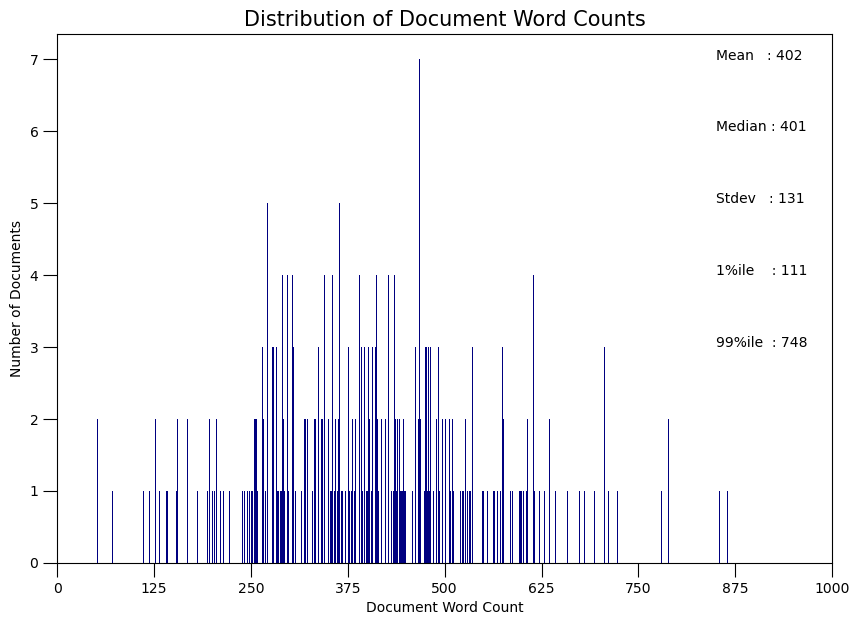

In [124]:
doc_lens = [len(d) for d in df_topic_sents_keywords.Text]

# Plot
plt.figure(figsize=(10,7), dpi=100)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(850, 7, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(850,  6, "Median : " + str(round(np.median(doc_lens))))
plt.text(850,  5, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(850,  4, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(850,  3, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=10)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=15))
plt.show()

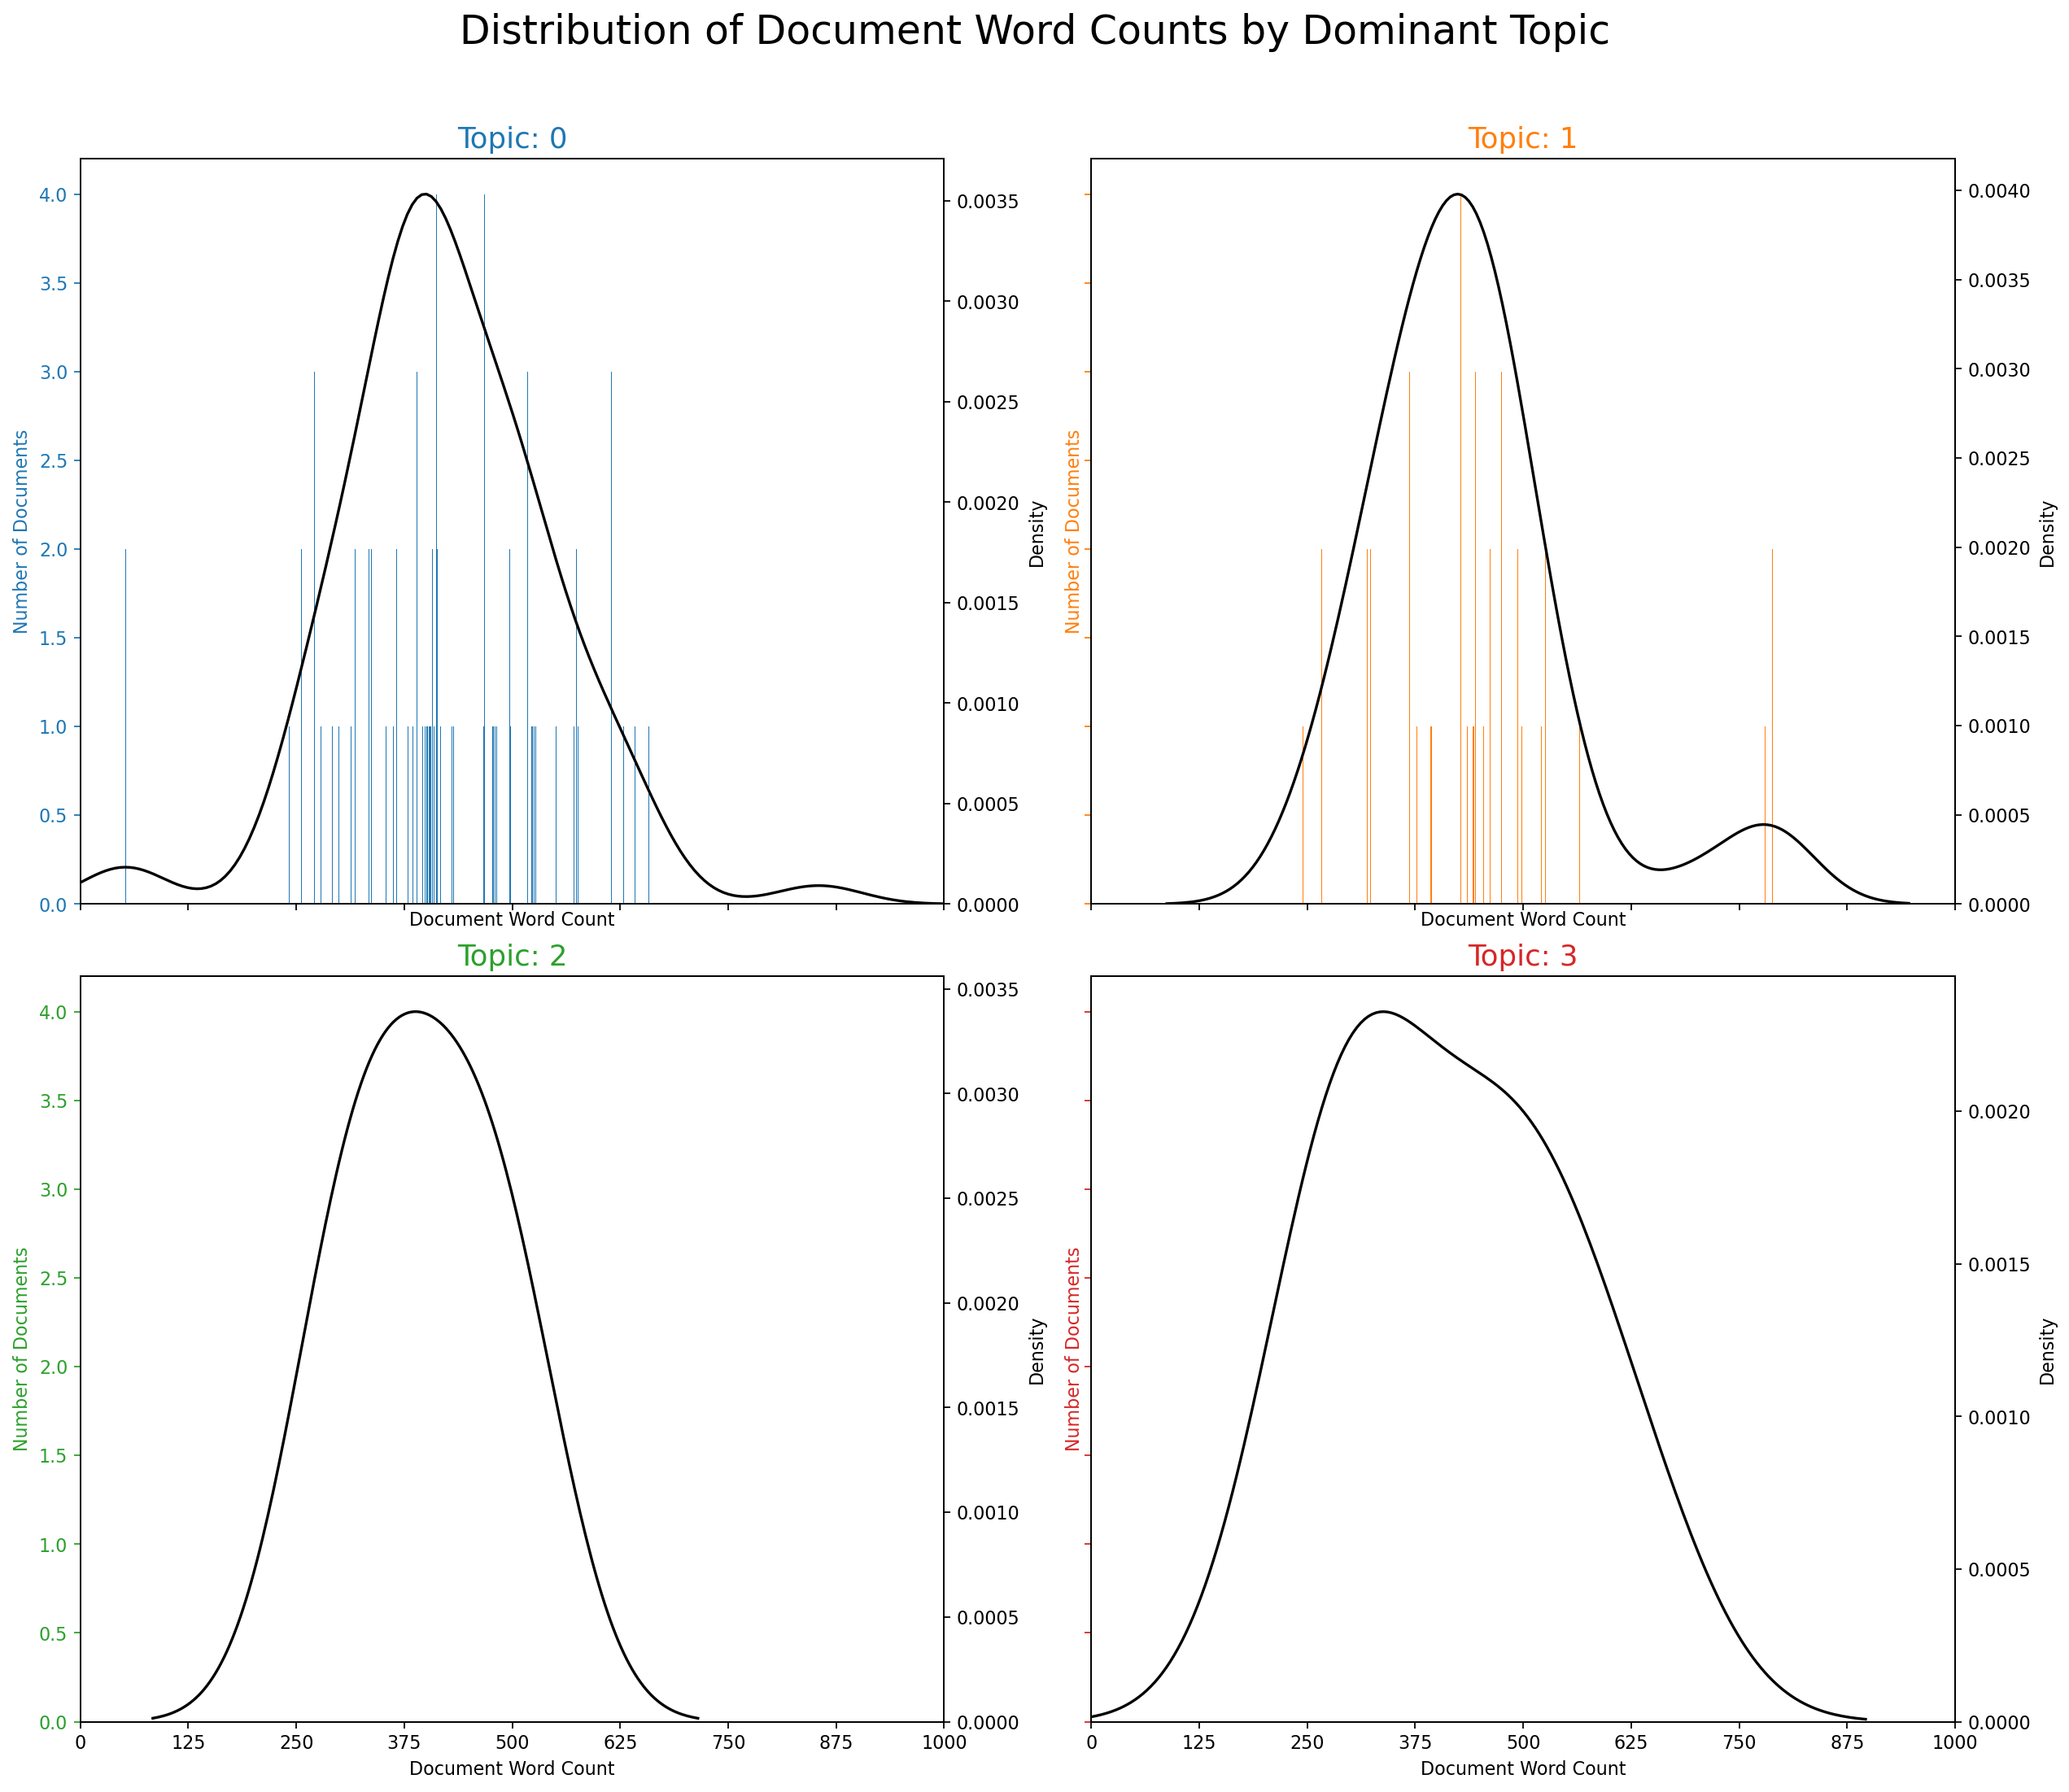

In [126]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_topic_sents_keywords.loc[df_topic_sents_keywords.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Word Clouds of Top N Keywords in Each Topic

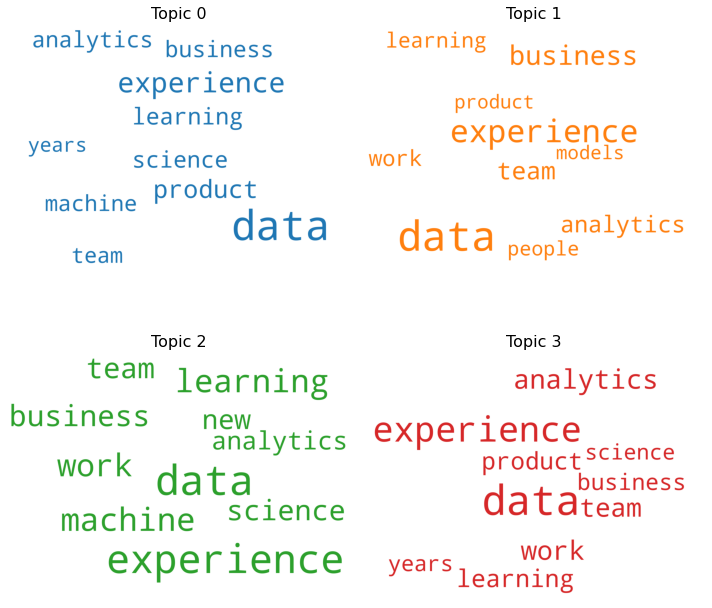

In [127]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

<ipython-input-129-b1472ffb4849>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-129-b1472ffb4849>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-129-b1472ffb4849>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-129-b1472ffb4849>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


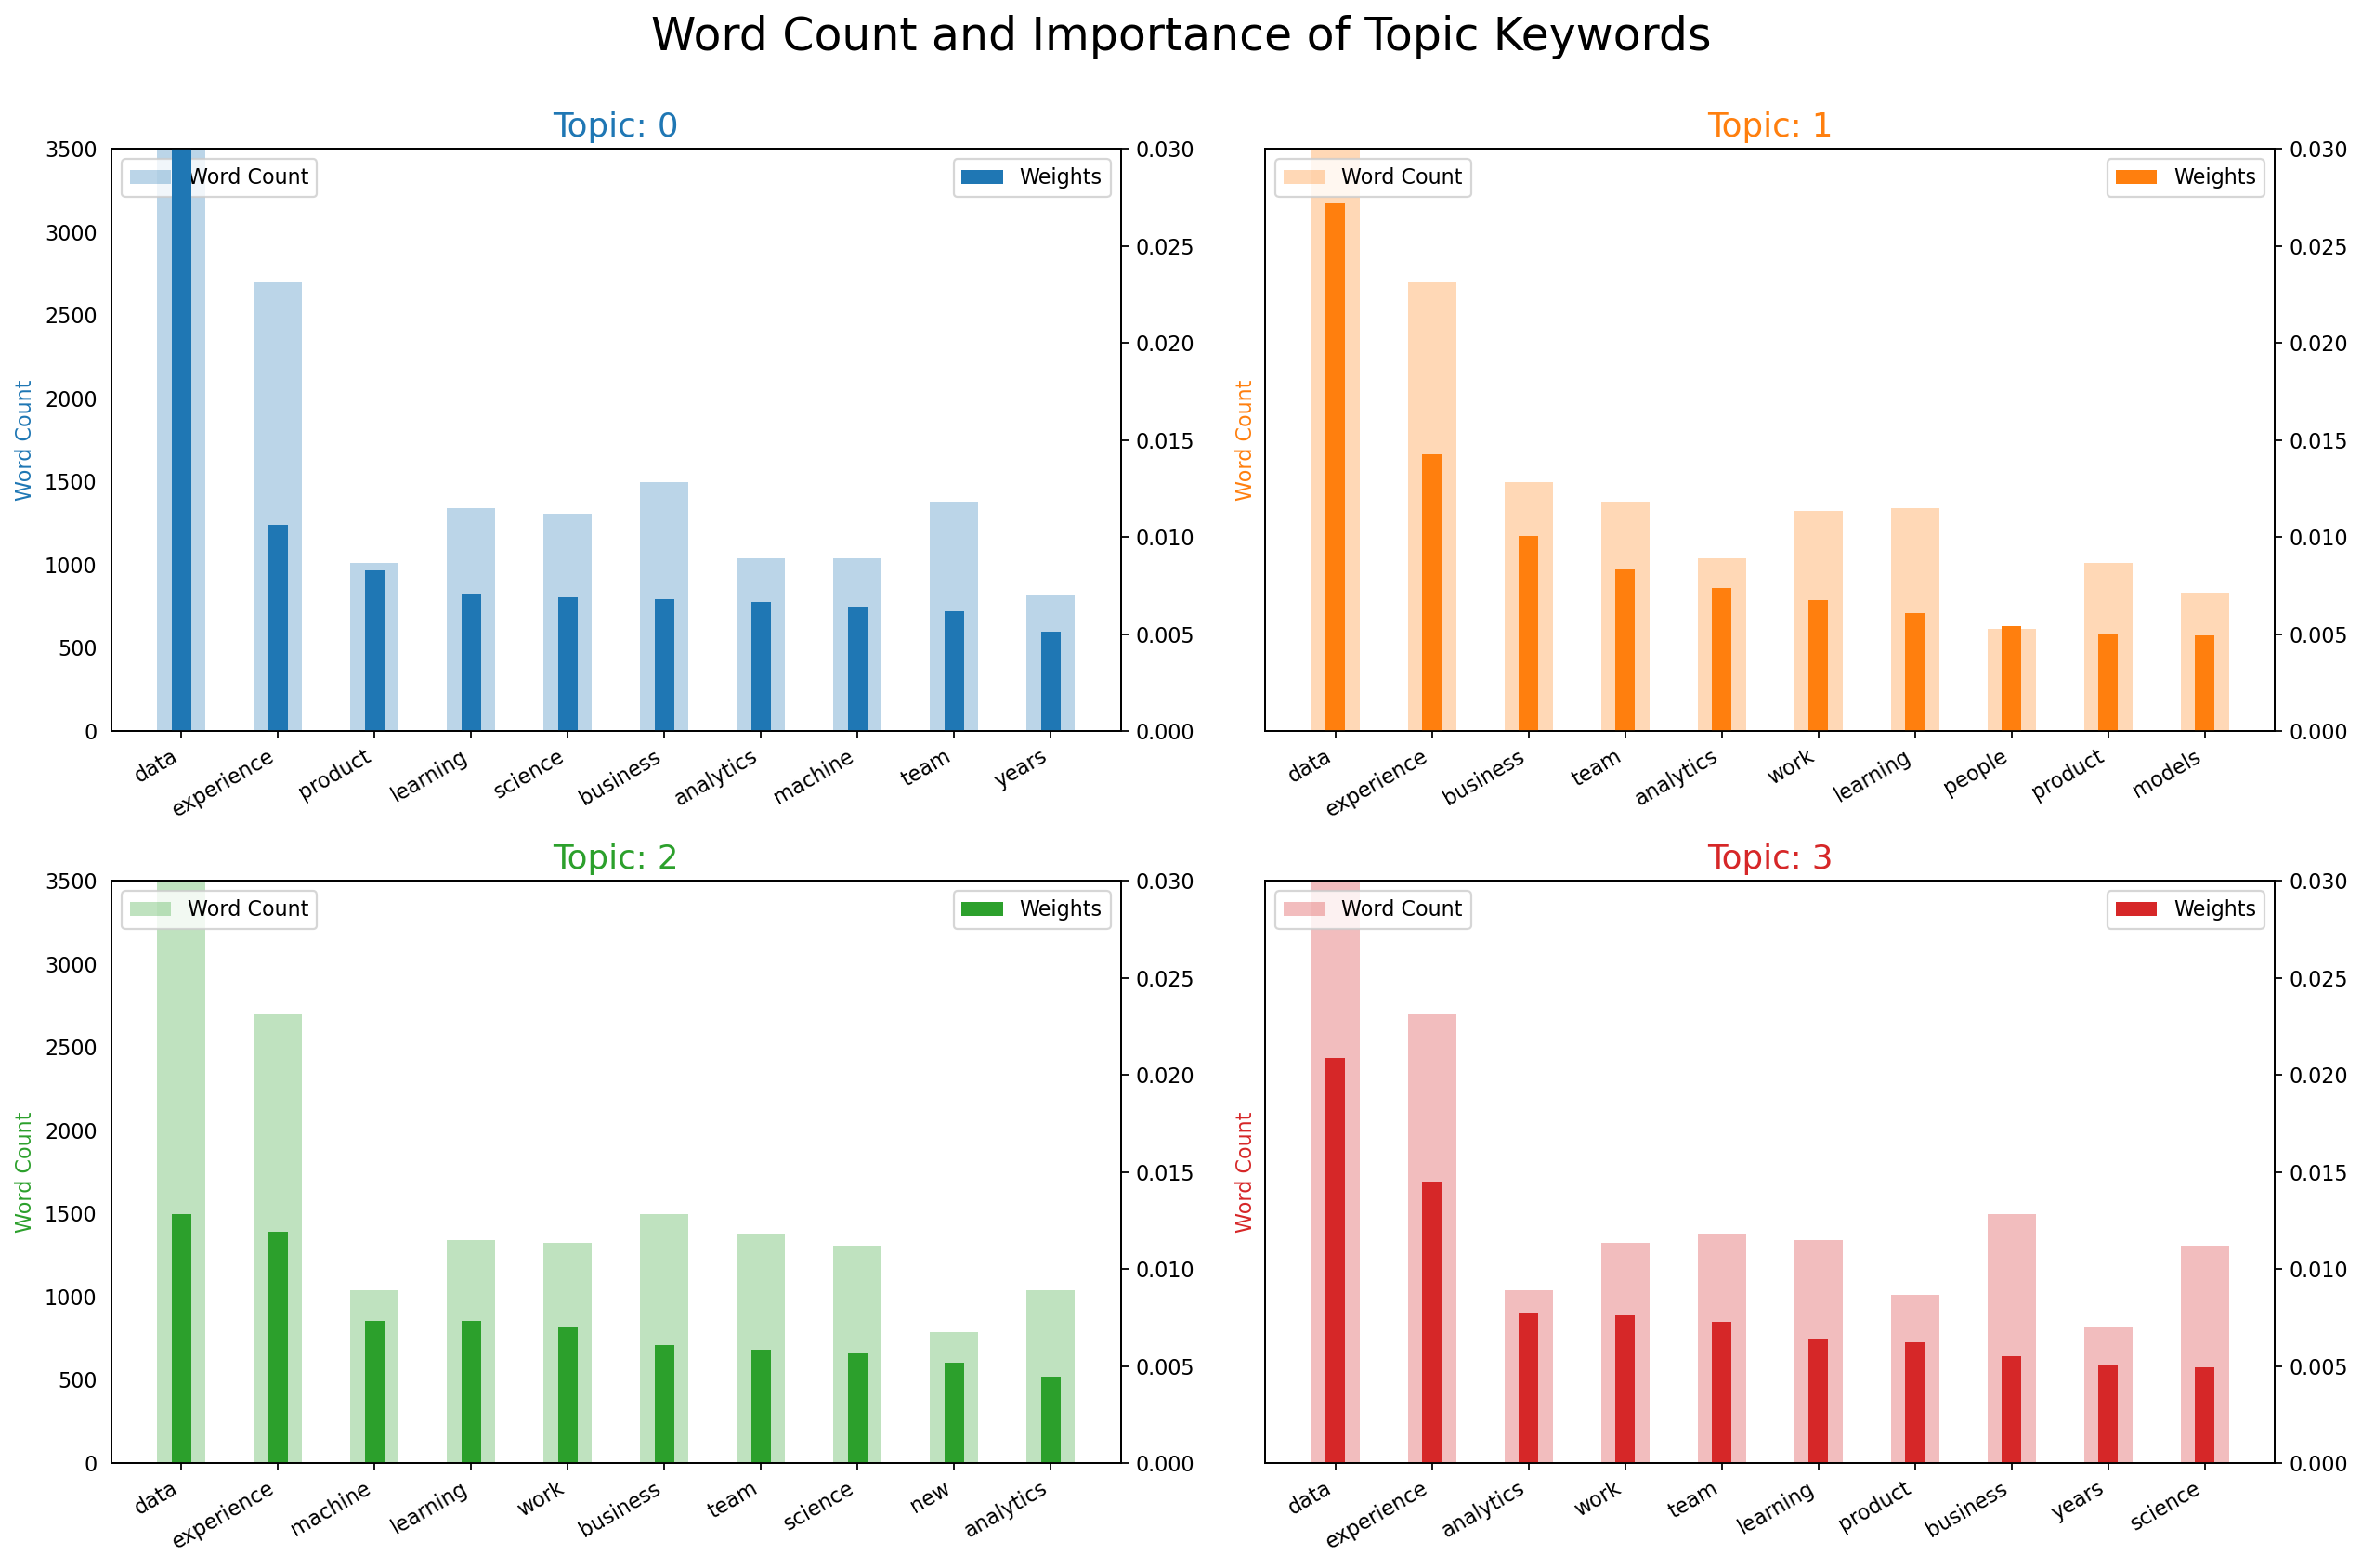

In [129]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [140]:
[*lda_model[corpus]][0]

[(0, 0.0737571), (5, 0.72989464), (6, 0.1881581)]

In [141]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 456 samples in 0.005s...
[t-SNE] Computed neighbors for 456 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 456 / 456
[t-SNE] Mean sigma: 0.000954
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.158638
[t-SNE] KL divergence after 1000 iterations: 0.179638


Loading BokehJS ...

# Python LDA Visualization (pyLDAvis)

In [98]:
# Note that the name of this function has been renamed - it is no longer gensim -- it is not gensim_models as for the newest version
import pyLDAvis.gensim_models

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.006638  0.005398       1        1  34.761842
0      0.009727  0.002686       2        1  20.988982
1      0.007081 -0.003267       3        1  13.887373
6      0.005043  0.001097       4        1  12.290497
5     -0.000437  0.006981       5        1   7.802143
9     -0.002742  0.005569       6        1   4.498387
7      0.005410 -0.010649       7        1   1.930095
8     -0.015590  0.004744       8        1   1.740706
3     -0.001145 -0.005459       9        1   1.198098
2     -0.013984 -0.007101      10        1   0.901877, topic_info=           Term         Freq        Total Category  logprob  loglift
47         data  5802.000000  5802.000000  Default  30.0000  30.0000
85   experience  2583.000000  2583.000000  Default  29.0000  29.0000
123    learning  1313.000000  1313.000000  Default  28.0000  28.0000
249        work  1328.000000  1328.000000  Default  27.0000  27.0000
27     business  1465.000000  1465.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
258    analysis     4.756024   736.907918  Topic10  -5.8530  -0.3346
254      across     4.284415   521.678525  Topic10  -5.9574  -0.0936
232       tools     4.146723   507.201212  Topic10  -5.9901  -0.0981
0       ability     4.186673   554.176727  Topic10  -5.9805  -0.1771
172    products     3.999380   484.930499  Topic10  -6.0262  -0.0894

[845 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.339242  ability
0         2  0.229169  ability
0         3  0.144358  ability
0         4  0.115487  ability
0         5  0.072179  ability
...     ...       ...      ...
252       8  0.017950    years
252       9  0.014103    years
252      10  0.008975    years
7545      1  0.363216      yoe
7545      3  0.363216      yoe

[2492 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 7, 6, 10, 8, 9, 4, 3])

# Non-negative Matrix Factorization

Now, I will try to apply a matrix factorization to the dataframe. We start by reproducing the documentation example:

In [16]:
def matrix_factorization(R, P, Q, K, steps=5000, 
                alpha=0.0002, beta=0.02):
    
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * 
                                Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * 
                            eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) 
                                + pow(Q[k][j],2))
        if e < 0.001:
            break
    return P, Q.T



In [17]:
R = [
     [5,3,0,1],
     [4,0,0,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4],
    ]
 
R = np.array(R)

N = len(R)
M = len(R[0])
K = 2
 
P = np.random.rand(N,K)
Q = np.random.rand(M,K)
 
nP, nQ = matrix_factorization(R, P, Q, K)
nR = np.dot(nP, nQ.T)



In [20]:
print(R)
print("~~~~~~~~~~~~~~~~")
print(P)
print("~~~~~~~~~~~~~~~~")
print(Q)
print("~~~~~~~~~~~~~~~~")
print(nR)

[[5 3 0 1]
 [4 0 0 1]
 [1 1 0 5]
 [1 0 0 4]
 [0 1 5 4]]
~~~~~~~~~~~~~~~~
[[2.33735152 0.47536955]
 [1.80806381 0.45771185]
 [0.21727692 1.95025949]
 [0.18472065 1.56432009]
 [1.00075232 1.61346181]]
~~~~~~~~~~~~~~~~
[[ 2.08466052  0.35059526]
 [ 1.15747719  0.20067333]
 [ 2.25704927  1.60109912]
 [-0.0935873   2.5551066 ]]
~~~~~~~~~~~~~~~~
[[5.03924674 2.80082506 6.03663132 0.99587344]
 [3.92967083 2.18464317 4.81373115 1.00029077]
 [1.13670033 0.64285814 3.61296347 4.96278653]
 [0.93352305 0.52772727 2.92155513 3.97971707]
 [2.6519009  1.48212674 4.84205958 4.02890921]]
